In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat
from read_cats import GetSDSSCat

from utils import *

In [51]:
zbins = [(1.0,2.15), (2.15,2.5), (2.5,5.0)]
# zbins = [(0.1, 5.), (1.0, 5.0), (1.,2.15), (2.15,2.50),(2.50,5.0)]


# PACS channels
lambdas = [100, 160]#250, 350, 500]

# Cutouts (half-)size in pixels
npix    = {100:49, # PACS pixels are ~ 3  arcsec -> cutouts are 5'
           160:37,  # PACS pixels are ~ 4  arcsec -> cutouts are 5'
           250:25,  # SPIRE pixels are ~ 6  arcsec -> cutouts are 5'
           350:19,  # SPIRE pixels are ~ 8  arcsec -> cutouts are 5'
           500:13}  # SPIRE pixels are ~ 12 arcsec -> cutouts are 5'

# Beam @ different freq
psf     = {100:11.4, # in arcsec
           160:13.7, # in arcsec
           250:17.8, # in arcsec
           350:24.0, # in arcsec
           500:35.2} # in arcsec

factor  = {100:1., 		   # Jy/pixel
           160:1,  		   # Jy/pixel
           250:469./36.,   # Jy/beam -> Jy/pixel
           350:831./64.,   # Jy/beam -> Jy/pixel
           500:1804./144.} # Jy/beam -> Jy/pixel

# Pixel resolution
reso    = {100:3.,  # in arcsec
           160:4.,  # in arcsec
           250:6.,  # in arcsec
           350:8.,  # in arcsec
           500:12.} # in arcsec

positions = {100: (49.5,49.5),
             160: (37.5,37.5),
             250: (25.5,25.5), 
             350: (19.5,19.5), 
             500: (13.5,13.5)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']


In [37]:
anal_bins = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE/', zbins=[(1.0,2.15), (2.15,2.5), (2.5,5.0)], lambdas=[100,160,250,350,500])

In [128]:
def do_thumbnails_plot(anal, remove_mean=True, remove_max=0, interpolation='bicubic', cmap='bone', fname=None):
    fig = plt.figure(figsize=(10,10))
    i=1
    plt.suptitle(r'H-ATLAS 5 arcmin x 5 arcmin [mJy/pixel]')
    for lambda_ in anal.lambdas:
        for zbin, zbin_edg in enumerate(anal.zbins):
            ax = fig.add_subplot(5, 3, i)
            if i < 4:
                plt.title(r'$%.2f < z < %.2f$' %(zbin_edg[0],zbin_edg[1]), size=15)
#                 print zbin_edg
            simuls = {}
            noises = {}
            for patch in anal.patches:
                simuls[patch] = anal.cuts[lambda_][patch][zbin].copy()
                try:
                    noises[patch] = anal.noise[lambda_][patch][zbin].copy()
                except:
                    pass

            if remove_max > 0:
                for patch in anal.patches:
                    for _ in xrange(remove_max):
                        killme = np.argmax(np.mean(simuls[patch], axis=(1,2)))
                        simuls[patch] = np.delete(simuls[patch], killme, axis=0)
                        try:
                            noises[patch] = np.delete(noises[patch], killme, axis=0)
                        except:
                            pass

            if remove_mean:
                for patch in anal.patches:
                    simuls[patch] -= anal.bkd[lambda_][patch][zbin].mean()
                    # simuls[patch] = np.asarray([simuls[patch][i]-simuls[patch][i].mean(0) for i in xrange(simuls[patch].shape[0])])


            data = np.concatenate([simuls[patch].copy() for patch in anal.patches], axis=0).mean(0)

            # Stuff for inverse variance weighting
            # data = np.concatenate([simuls[patch].copy()/noises[patch].copy()**2 for patch in self.patches], axis=0)#
            # nois = np.concatenate([1/noises[patch].copy()**2 for patch in self.patches], axis=0)#
            # data = data.mean(0)/nois.mean(0)

            # Stuff for variance weighting
            # data = np.concatenate([simuls[patch].copy()*noises[patch].copy() for patch in self.patches], axis=0)
            # nois = np.concatenate([noises[patch].copy() for patch in self.patches], axis=0)
            # data = data.mean(0)/nois.mean(0)

            # plt.imshow(data/data1-1., vmin=-10, vmax=10)
            # plt.colorbar()
            # plt.show()

            # plt.subplot(131)
            # plt.imshow(nois.mean(0), interpolation='bicubic'); plt.colorbar()
            # plt.subplot(132)
            # plt.imshow(data, interpolation='bicubic'); plt.colorbar()
            # plt.subplot(133)
            # plt.imshow(data1, interpolation='bicubic'); plt.colorbar()
            # plt.show()


            # Jy/beam -> mJy/beam
            data /= 1e-3
            
            im = plt.imshow(data,extent=[0,anal.boxsize[lambda_],0,anal.boxsize[lambda_]], interpolation=interpolation, cmap=cmap)
            if i == 1 or i == 4 or i == 7 or i == 10 or i == 13:
                plt.ylabel( r' $\lambda= $ ' +str(lambda_) + r'$\mu m$', size=15)

            # To show PSF
            circin = plt.Circle((40/reso[lambda_],40/reso[lambda_]), radius=psf[lambda_]/reso[lambda_], color='tomato', fill=False)
            ax.add_patch(circin)

            # Ticks stuff
            ax.tick_params(axis='both', direction='in')
            ax.minorticks_on()
            ax.tick_params(axis='both', direction='in', which='minor', bottom='on', top='on', left='on', right='on')
            plt.colorbar()
#             plt.plot(positions[lambda_], 'w+', mew=2

            # Remove tick lables
            labels = [item.get_text() for item in ax.get_xticklabels()]

            empty_string_labels = ['']*len(labels)
            ax.set_xticklabels(empty_string_labels)
            ax.set_yticklabels(empty_string_labels)

            i += 1
            
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    if fname is not None:
        plt.savefig(fname)
    plt.show()
    


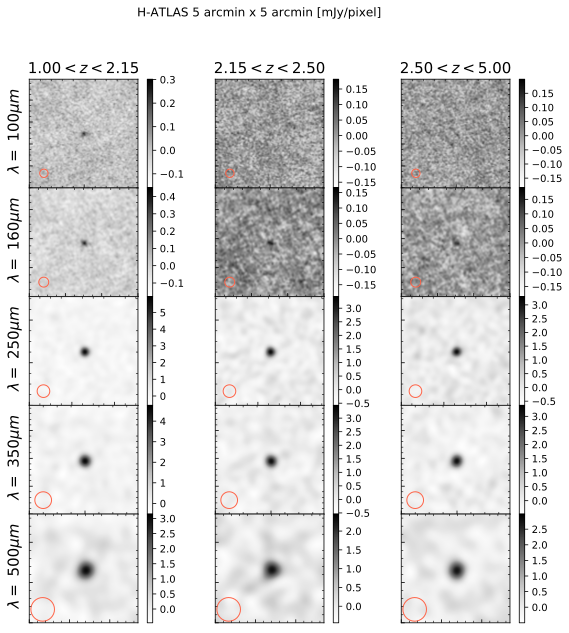

In [134]:
do_thumbnails_plot(anal_bins, remove_max=4, cmap='Greys', fname='/Users/fbianchini/Research/StacktSZ/H-ATLAS_stamps_paper_Greys.pdf')